# Decision Tree


In [1]:
import numpy as np
from collections import Counter

class TreeNode:
    def __init__(self, data, split_feature_idx=None, split_feature_val=None, label_probabilities=None, information_gain=None):
        self.data = data
        self.split_feature_idx = split_feature_idx
        self.split_feature_val = split_feature_val
        self.label_probabilities = label_probabilities
        self.information_gain = information_gain
        self.left_child = None
        self.right_child = None

    def node_def(self):
        return f"Split on feature {self.split_feature_idx} < {self.split_feature_val}, Label Probs: {self.label_probabilities}"

class DecisionTree():
    def __init__(self, max_depth=4, min_samples_leaf=1,
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say
        self.tree = None
        self.labels_in_train = []

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p > 0])

    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))

    def _partition_entropy(self, subsets: list) -> float:
        total_count = sum(len(subset) for subset in subsets)
        return sum(self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets)

    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]
        return group1, group2

    def _select_features_to_use(self, data: np.array) -> list:
        feature_idx = list(range(data.shape[1] - 1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))), replace=False)
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))), replace=False)
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use

    def _find_best_split(self, data: np.array) -> tuple:
        min_part_entropy = float('inf')
        feature_idx_to_use = self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2 = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_label_probs(self, data: np.array) -> np.array:
        labels_as_integers = data[:, -1].astype(int)
        total_labels = len(labels_as_integers)
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == label)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        if current_depth > self.max_depth:
            return None

        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)

        label_probabilities = self._find_label_probs(data)

        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy

        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node

        if information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left_child = self._create_tree(split_1_data, current_depth)
        node.right_child = self._create_tree(split_2_data, current_depth)

        return node

    def _predict_one_sample(self, X: np.array) -> np.array:
        node = self.tree

        while node:
            pred_probs = node.label_probabilities
            if X[node.split_feature_idx] < node.split_feature_val:
                node = node.left_child
            else:
                node = node.right_child

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        self.tree = self._create_tree(data=train_data, current_depth=0)

    def predict_proba(self, X_set: np.array) -> np.array:
        return np.array([self._predict_one_sample(x) for x in X_set])

    def predict(self, X_set: np.array) -> np.array:
        probas = self.predict_proba(X_set)
        return np.argmax(probas, axis=1)


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv('/content/titatinic.csv')

In [4]:
df['Age'].fillna(df['Age'].median(), inplace=True)

<ipython-input-4-63d4fb902a4f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


In [5]:
#Converting the categorical column to numerical
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [6]:
X = np.array(df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']])
y = np.array(df['Survived'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (712, 6)
Test Shape: (179, 6)


In [9]:
clf = DecisionTreeClassifier(max_depth = 5)

In [10]:
clf = clf.fit(X_train,y_train)

In [11]:
y_pred = clf.predict(X_test)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[95 10]
 [25 49]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



In [13]:
test_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


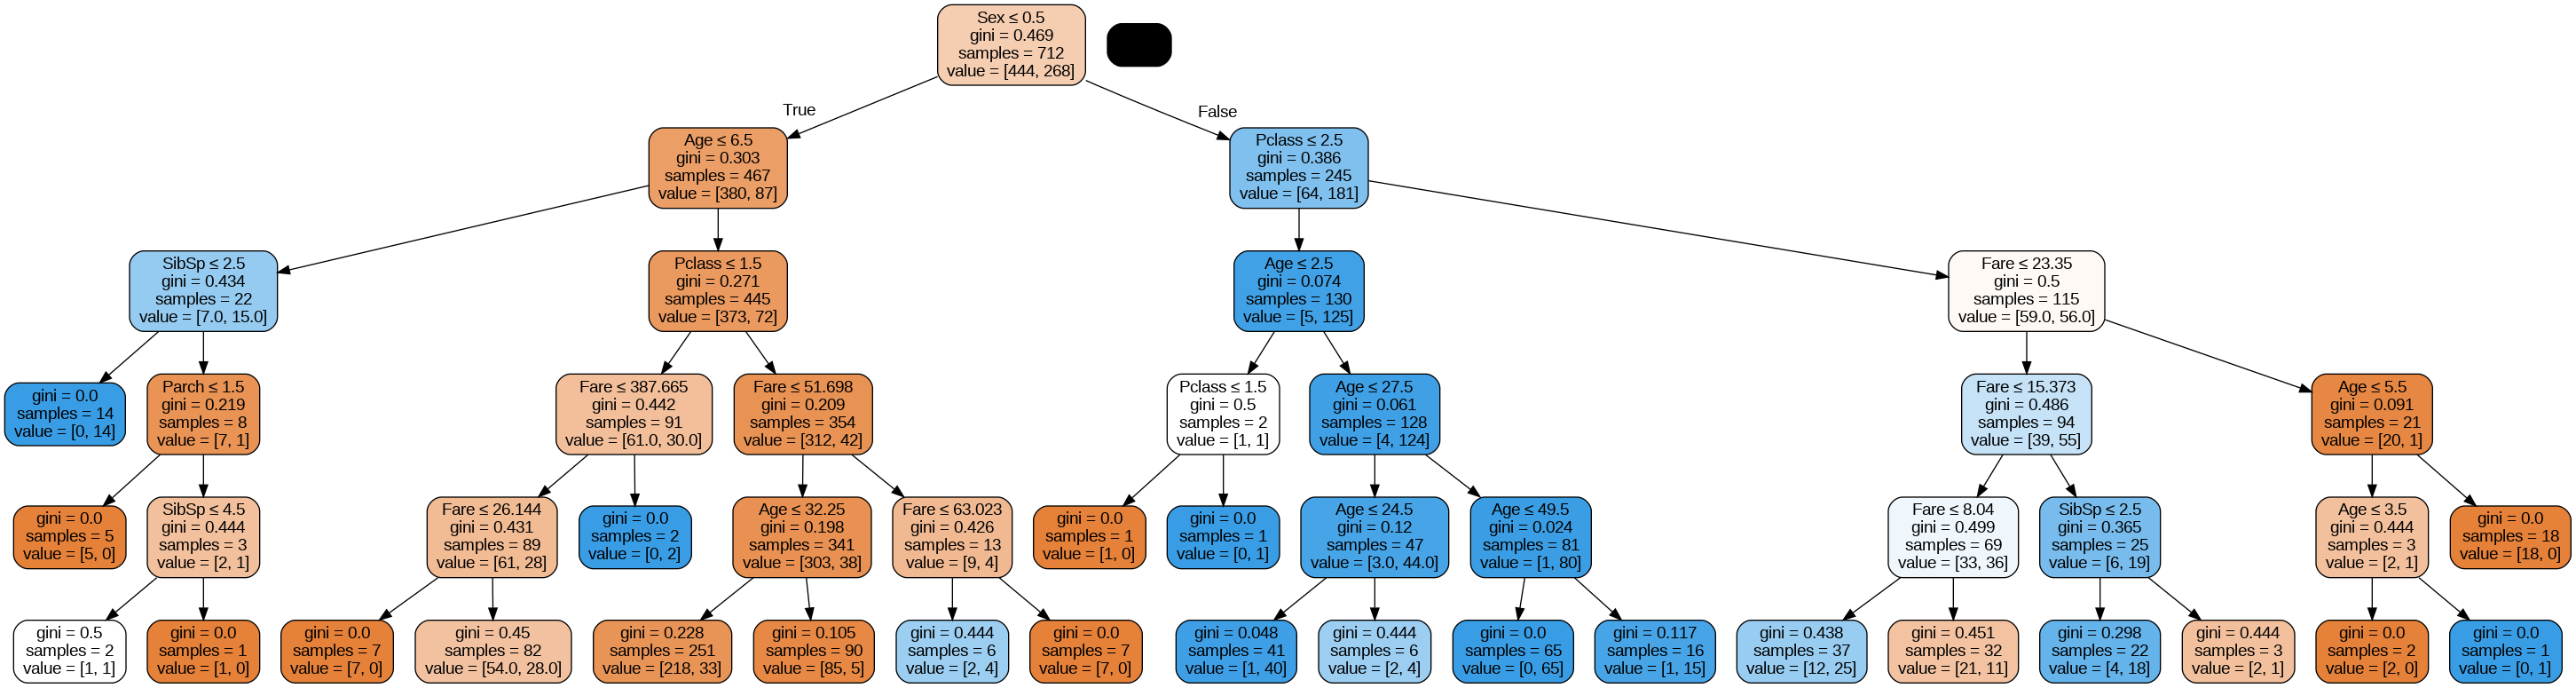

In [14]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = test_features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('titanic.png')
Image(graph.create_png())

This implementation defines a basic decision tree classifier using entropy as the measure of impurity and information gain as the splitting criterion. The TreeNode class represents individual nodes in the decision tree, storing the feature and value used to split data, label probabilities, and information gain. The tree itself is built recursively by selecting the best feature and value to split on, based on minimizing entropy (uncertainty). The algorithm selects a subset of features (depending on the configuration) and finds the best split based on percentile values of those features.

The main class, DecisionTree, handles various aspects such as calculating entropy, finding label probabilities, and selecting features to consider during splits. The core method, _create_tree, builds the tree by recursively splitting data into two groups, minimizing entropy at each step. Stopping conditions include reaching the maximum depth, insufficient samples in a split, or a low information gain. The prediction methods use the trained tree to assign probabilities to class labels, ultimately returning the most likely class.

The approach emphasizes efficiency through feature selection (such as using only a subset of features for splitting) and leverages the information-theoretic concept of entropy for decision-making. The implementation is flexible, allowing customization of tree depth, minimum information gain, and minimum samples in leaf nodes, making it suitable for handling different classification tasks.

# Random Forest


In [15]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [16]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
y_pred = rf.predict(X_test)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[90 15]
 [18 56]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



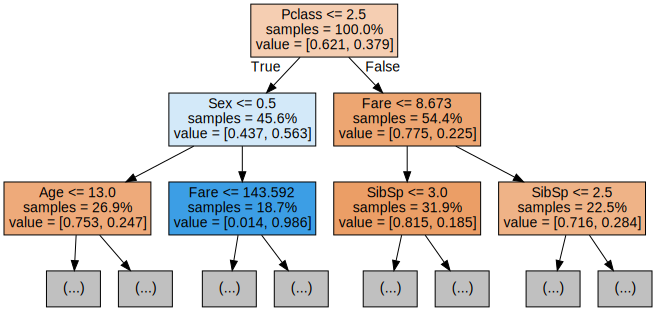

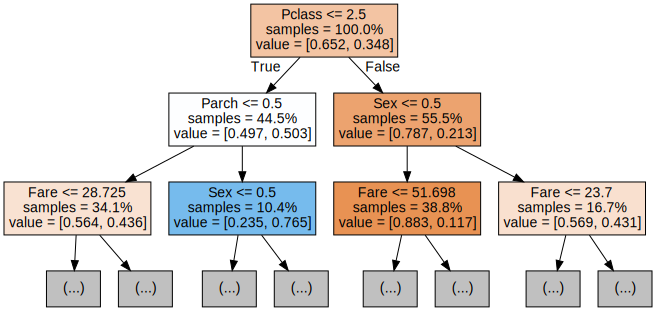

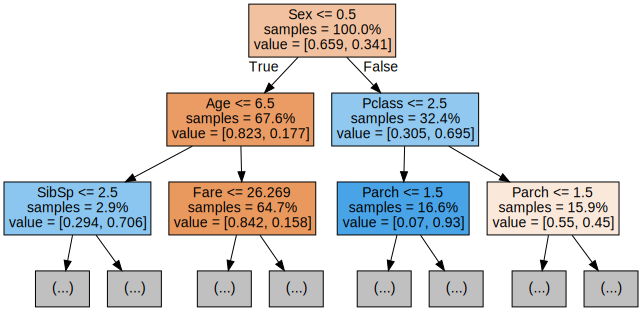

In [19]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=test_features,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [20]:
!pip install gradio scikit-learn numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [21]:
from sklearn.ensemble import RandomForestClassifier
import joblib
# Assuming X_train and y_train are your training data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(rf, "rf_model.pkl")


['rf_model.pkl']

In [23]:
df['Pclass'].unique()

array([3, 1, 2])

In [24]:
df['Sex'].unique()

array([0, 1])

In [30]:
df['Age'].min()

0.42

In [51]:
df['Age'].max()

80

In [41]:
df['Age'] = df['Age'].round().astype(int)


In [44]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [55]:
df['Survived'].unique()

array([0, 1])

In [45]:
df['SibSp'].value_counts()

,count
SibSp,
0,608
1,209
2,28
4,18
3,16
8,7
5,5


In [46]:
df['Parch'].value_counts()

,count
Parch,
0,678
1,118
2,80
5,5
3,5
4,4
6,1


In [50]:
print(df['Fare'].min())
print(df['Fare'].max())

0.0
512.3292


In [56]:
import gradio as gr
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load the trained model
rf = joblib.load("rf_model.pkl")

# Define a function for prediction using the trained model
def predict_class(feature1, feature2, feature3, feature4, feature5, feature6):
    # Create an array of the input features
    input_data = np.array([feature1, feature2, feature3, feature4, feature5, feature6]).reshape(1, -1)

    # Make the prediction
    prediction = rf.predict(input_data)

    if prediction == 0:
        return "Did not survive"
    else:
        return "Survived"

# Define a function to handle the input and make a prediction
def process_input(PClass, Sex, Age, Sibsp, Parch, Fare):
    # Map Sex to numeric values
    if Sex == "Male":
        sex_value = 0  # Male = 0
    else:
        sex_value = 1  # Female = 1

    # Use the RandomForest model to predict the class
    predicted_class = predict_class(PClass, sex_value, Age, Sibsp, Parch, Fare)

    # Return the prediction result
    return predicted_class

# Create the Gradio UI
def create_gradio_ui():
    inputs = [
        gr.Radio(choices=[1, 2, 3], label="PClass", type="value"),
        gr.Radio(choices=["Male", "Female"], label="Sex", type="value"),
        gr.Number(label="Age"),
        gr.Number(label="Sibsp"),
        gr.Number(label="Parch"),
        gr.Number(label="Fare")
    ]

    # Output to display the processed result
    output = gr.Textbox(label="Prediction Result")

    # Create the interface
    interface = gr.Interface(
        fn=process_input,  # The function to process inputs and make predictions
        inputs=inputs,     # The input widgets
        outputs=output     # The output widget
    )

    # Launch the Gradio interface
    interface.launch()

# Run the UI
if __name__ == "__main__":
    create_gradio_ui()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://408d6d77c08466ac1b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
